In [1]:
import os
import pandas as pd

# Define folder path
folder_path = 'cropped/'

# Function to get filenames with specific extensions
def get_filenames(folder_path, extensions):
    filenames = []
    for file in os.listdir(folder_path):
        if file.endswith(extensions):
            filenames.append(file)
    return filenames

# Get list of jpeg and txt filenames
jpeg_files = get_filenames(folder_path, '.jpg')
txt_files = get_filenames(folder_path, '.txt')

# Create DataFrame
data = []
for jpeg_file in jpeg_files:
    filename, _ = os.path.splitext(jpeg_file)
    filename_fixed = filename.replace("cropped_line", "text")
    matching_txt = [txt for txt in txt_files if txt.startswith(filename_fixed)]
    if not matching_txt:
      continue
    try:
      with open(f"{folder_path}/{matching_txt[0]}") as text_file:
        text = text_file.read()
        if text:
            data.append({'file_name': jpeg_file, 'text': text})
        else:
            data.append({'file_name': jpeg_file, 'text': ''})
    except FileNotFoundError as e:
      print(e)

df = pd.DataFrame(data)
df

Files: ['image_serial_12_12_cropped_line.jpg', 'image_serial_37_14_cropped_line.jpg', 'image_serial_34_41_cropped_line.jpg', 'image_serial_32_23_cropped_line.jpg', 'image_serial_34_46_cropped_line.jpg', 'image_serial_48_3_cropped_line.jpg', 'image_serial_50_11_cropped_line.jpg', 'image_serial_21_9_cropped_line.jpg', 'image_serial_53_1_cropped_line.jpg', 'image_serial_24_9_cropped_line.jpg', 'image_serial_29_26_cropped_line.jpg', 'image_serial_131_29_cropped_line.jpg', 'image_serial_128_6_cropped_line.jpg', 'image_serial_45_16_cropped_line.jpg', 'image_serial_25_12_cropped_line.jpg', 'image_serial_22_17_cropped_line.jpg', 'image_serial_129_31_cropped_line.jpg', 'image_serial_131_28_cropped_line.jpg', 'image_serial_51_49_cropped_line.jpg', 'image_serial_46_33_cropped_line.jpg', 'image_serial_41_5_cropped_line.jpg', 'image_serial_40_30_cropped_line.jpg', 'image_serial_22_3_cropped_line.jpg', 'image_serial_39_2_cropped_line.jpg', 'image_serial_17_24_cropped_line.jpg', 'image_serial_48_31_c

In [2]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [4]:
from transformers import TrOCRProcessor

# get the hugging face model and show it the data 
processor = TrOCRProcessor.from_pretrained("raxtemur/trocr-base-ru")
train_dataset = IAMDataset(root_dir='cropped/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='cropped/',
                           df=test_df,
                           processor=processor)

/home/maria/projects/blok/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 1344
Number of validation examples: 337


In [6]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


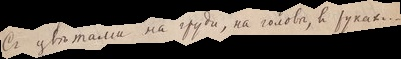

In [7]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [8]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

–°—ä —Ü–≤—£—Ç–∞–º–∏ –Ω–∞ –≥—Ä—É–¥–∏, –Ω–∞ –≥–æ–ª–æ–≤—£, –≤—ä —Ä—É–∫–∞—Ö—ä...


In [9]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("raxtemur/trocr-base-ru")

/home/maria/projects/blok/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [87]:
# the config I didn't use because it's already in the model

# # set special tokens used for creating the decoder_input_ids from the labels
# model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
# model.config.pad_token_id = processor.tokenizer.pad_token_id
# # make sure vocab size is set correctly
# model.config.vocab_size = model.config.decoder.vocab_size

# # set beam search parameters
# model.config.eos_token_id = processor.tokenizer.sep_token_id
# model.config.max_length = 64
# model.config.early_stopping = True
# model.config.no_repeat_ngram_size = 3
# model.config.length_penalty = 2.0
# model.config.num_beams = 4

In [10]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=False,  # turn it off because my model didn't like it
    output_dir="model",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [11]:
from datasets import load_metric

cer_metric = load_metric("cer")

/tmp/ipykernel_2160076/152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library ü§ó Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/home/maria/projects/blok/venv/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [12]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [17]:
#  define the folder to save trained model
trainer.save_model("model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64}


In [13]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/home/maria/projects/blok/venv/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
  0%|          | 2/504 [00:23<1:36:37, 11.55s/it]

{'loss': 1.5437, 'grad_norm': 9.51470947265625, 'learning_rate': 4.9801587301587306e-05, 'epoch': 0.01}


  1%|          | 4/504 [00:45<1:35:22, 11.45s/it]

{'loss': 1.0926, 'grad_norm': 8.087806701660156, 'learning_rate': 4.960317460317461e-05, 'epoch': 0.02}


  1%|          | 6/504 [01:06<1:30:26, 10.90s/it]

{'loss': 0.8643, 'grad_norm': 18.628372192382812, 'learning_rate': 4.940476190476191e-05, 'epoch': 0.04}


  2%|‚ñè         | 8/504 [01:27<1:28:28, 10.70s/it]

{'loss': 0.6795, 'grad_norm': 13.90930461883545, 'learning_rate': 4.9206349206349204e-05, 'epoch': 0.05}


  2%|‚ñè         | 10/504 [01:49<1:28:15, 10.72s/it]

{'loss': 0.5856, 'grad_norm': 4.585747241973877, 'learning_rate': 4.900793650793651e-05, 'epoch': 0.06}


  2%|‚ñè         | 12/504 [02:11<1:28:22, 10.78s/it]

{'loss': 0.5071, 'grad_norm': 4.025274753570557, 'learning_rate': 4.880952380952381e-05, 'epoch': 0.07}


  3%|‚ñé         | 14/504 [02:32<1:27:27, 10.71s/it]

{'loss': 0.4196, 'grad_norm': 4.651594638824463, 'learning_rate': 4.8611111111111115e-05, 'epoch': 0.08}


  3%|‚ñé         | 16/504 [02:55<1:29:24, 10.99s/it]

{'loss': 0.3794, 'grad_norm': 3.9300625324249268, 'learning_rate': 4.841269841269841e-05, 'epoch': 0.1}


  4%|‚ñé         | 18/504 [03:21<1:37:49, 12.08s/it]

{'loss': 0.2725, 'grad_norm': 3.3276925086975098, 'learning_rate': 4.8214285714285716e-05, 'epoch': 0.11}


  4%|‚ñç         | 20/504 [03:43<1:33:45, 11.62s/it]

{'loss': 0.3523, 'grad_norm': 3.3639628887176514, 'learning_rate': 4.801587301587302e-05, 'epoch': 0.12}


  4%|‚ñç         | 22/504 [04:05<1:30:08, 11.22s/it]

{'loss': 0.7775, 'grad_norm': 3.9229650497436523, 'learning_rate': 4.781746031746032e-05, 'epoch': 0.13}


  5%|‚ñç         | 24/504 [04:29<1:34:00, 11.75s/it]

{'loss': 0.2899, 'grad_norm': 2.950727701187134, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.14}


  5%|‚ñå         | 26/504 [04:52<1:32:35, 11.62s/it]

{'loss': 0.2993, 'grad_norm': 2.326591968536377, 'learning_rate': 4.7420634920634924e-05, 'epoch': 0.15}


  6%|‚ñå         | 28/504 [05:16<1:32:18, 11.64s/it]

{'loss': 0.4104, 'grad_norm': 3.659022808074951, 'learning_rate': 4.722222222222222e-05, 'epoch': 0.17}


  6%|‚ñå         | 30/504 [05:39<1:31:27, 11.58s/it]

{'loss': 0.2482, 'grad_norm': 3.978132724761963, 'learning_rate': 4.7023809523809525e-05, 'epoch': 0.18}


  6%|‚ñã         | 32/504 [06:03<1:33:28, 11.88s/it]

{'loss': 0.2998, 'grad_norm': 3.7969436645507812, 'learning_rate': 4.682539682539683e-05, 'epoch': 0.19}


  7%|‚ñã         | 34/504 [06:27<1:33:57, 11.99s/it]

{'loss': 0.2814, 'grad_norm': 3.403782367706299, 'learning_rate': 4.662698412698413e-05, 'epoch': 0.2}


  7%|‚ñã         | 36/504 [06:51<1:32:38, 11.88s/it]

{'loss': 0.2834, 'grad_norm': 3.093905210494995, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.21}


  8%|‚ñä         | 38/504 [07:13<1:29:08, 11.48s/it]

{'loss': 0.2481, 'grad_norm': 1.9351292848587036, 'learning_rate': 4.623015873015873e-05, 'epoch': 0.23}


  8%|‚ñä         | 40/504 [07:36<1:29:59, 11.64s/it]

{'loss': 0.1876, 'grad_norm': 1.770957589149475, 'learning_rate': 4.603174603174603e-05, 'epoch': 0.24}


  8%|‚ñä         | 42/504 [07:59<1:29:14, 11.59s/it]

{'loss': 0.3404, 'grad_norm': 2.6767423152923584, 'learning_rate': 4.5833333333333334e-05, 'epoch': 0.25}


  9%|‚ñä         | 44/504 [08:23<1:29:23, 11.66s/it]

{'loss': 0.3166, 'grad_norm': 3.4348649978637695, 'learning_rate': 4.563492063492064e-05, 'epoch': 0.26}


  9%|‚ñâ         | 46/504 [08:46<1:28:00, 11.53s/it]

{'loss': 0.2082, 'grad_norm': 3.489997625350952, 'learning_rate': 4.543650793650794e-05, 'epoch': 0.27}


 10%|‚ñâ         | 48/504 [09:12<1:35:07, 12.52s/it]

{'loss': 0.2625, 'grad_norm': 2.157973051071167, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.29}


 10%|‚ñâ         | 50/504 [09:36<1:33:03, 12.30s/it]

{'loss': 0.4827, 'grad_norm': 5.192949295043945, 'learning_rate': 4.503968253968254e-05, 'epoch': 0.3}


 10%|‚ñà         | 52/504 [10:03<1:35:44, 12.71s/it]

{'loss': 0.2864, 'grad_norm': 2.3127849102020264, 'learning_rate': 4.4841269841269846e-05, 'epoch': 0.31}


 11%|‚ñà         | 54/504 [10:26<1:30:32, 12.07s/it]

{'loss': 0.1494, 'grad_norm': 1.8128023147583008, 'learning_rate': 4.464285714285715e-05, 'epoch': 0.32}


 11%|‚ñà         | 56/504 [10:49<1:29:07, 11.94s/it]

{'loss': 0.2781, 'grad_norm': 3.5420007705688477, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.33}


 12%|‚ñà‚ñè        | 58/504 [11:14<1:29:55, 12.10s/it]

{'loss': 0.1653, 'grad_norm': 2.36010479927063, 'learning_rate': 4.4246031746031744e-05, 'epoch': 0.35}


 12%|‚ñà‚ñè        | 60/504 [11:36<1:26:52, 11.74s/it]

{'loss': 0.255, 'grad_norm': 2.6671082973480225, 'learning_rate': 4.404761904761905e-05, 'epoch': 0.36}


 12%|‚ñà‚ñè        | 62/504 [11:59<1:25:03, 11.55s/it]

{'loss': 0.2328, 'grad_norm': 3.981950521469116, 'learning_rate': 4.384920634920635e-05, 'epoch': 0.37}


 13%|‚ñà‚ñé        | 64/504 [12:22<1:23:26, 11.38s/it]

{'loss': 0.2624, 'grad_norm': 4.1267991065979, 'learning_rate': 4.3650793650793655e-05, 'epoch': 0.38}


 13%|‚ñà‚ñé        | 66/504 [12:45<1:23:22, 11.42s/it]

{'loss': 0.2211, 'grad_norm': 13.883563041687012, 'learning_rate': 4.345238095238096e-05, 'epoch': 0.39}


 13%|‚ñà‚ñé        | 68/504 [13:08<1:24:09, 11.58s/it]

{'loss': 0.1361, 'grad_norm': 2.587019681930542, 'learning_rate': 4.3253968253968256e-05, 'epoch': 0.4}


 14%|‚ñà‚ñç        | 70/504 [13:31<1:23:28, 11.54s/it]

{'loss': 0.2606, 'grad_norm': 4.761039733886719, 'learning_rate': 4.305555555555556e-05, 'epoch': 0.42}


 14%|‚ñà‚ñç        | 72/504 [13:54<1:22:24, 11.45s/it]

{'loss': 0.2112, 'grad_norm': 3.693406343460083, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.43}


 15%|‚ñà‚ñç        | 74/504 [14:18<1:25:31, 11.93s/it]

{'loss': 0.1606, 'grad_norm': 2.1961610317230225, 'learning_rate': 4.265873015873016e-05, 'epoch': 0.44}


 15%|‚ñà‚ñå        | 76/504 [14:43<1:26:33, 12.13s/it]

{'loss': 0.3747, 'grad_norm': 15.9905424118042, 'learning_rate': 4.2460317460317464e-05, 'epoch': 0.45}


 15%|‚ñà‚ñå        | 78/504 [15:06<1:24:10, 11.85s/it]

{'loss': 0.1934, 'grad_norm': 2.1392579078674316, 'learning_rate': 4.226190476190476e-05, 'epoch': 0.46}


 16%|‚ñà‚ñå        | 80/504 [15:29<1:22:38, 11.69s/it]

{'loss': 0.2262, 'grad_norm': 1.7615247964859009, 'learning_rate': 4.2063492063492065e-05, 'epoch': 0.48}


 16%|‚ñà‚ñã        | 82/504 [15:53<1:22:39, 11.75s/it]

{'loss': 0.1517, 'grad_norm': 1.3162872791290283, 'learning_rate': 4.186507936507937e-05, 'epoch': 0.49}


 17%|‚ñà‚ñã        | 84/504 [16:17<1:23:17, 11.90s/it]

{'loss': 0.1038, 'grad_norm': 1.5844025611877441, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.5}


 17%|‚ñà‚ñã        | 86/504 [16:41<1:23:26, 11.98s/it]

{'loss': 0.1989, 'grad_norm': 3.24811053276062, 'learning_rate': 4.1468253968253976e-05, 'epoch': 0.51}


 17%|‚ñà‚ñã        | 88/504 [17:05<1:22:57, 11.97s/it]

{'loss': 0.1953, 'grad_norm': 2.620392084121704, 'learning_rate': 4.126984126984127e-05, 'epoch': 0.52}


 18%|‚ñà‚ñä        | 90/504 [17:28<1:20:06, 11.61s/it]

{'loss': 0.272, 'grad_norm': 2.052253007888794, 'learning_rate': 4.107142857142857e-05, 'epoch': 0.54}


 18%|‚ñà‚ñä        | 92/504 [17:51<1:19:44, 11.61s/it]

{'loss': 0.0988, 'grad_norm': 1.4905415773391724, 'learning_rate': 4.0873015873015874e-05, 'epoch': 0.55}


 19%|‚ñà‚ñä        | 94/504 [18:14<1:18:41, 11.52s/it]

{'loss': 0.1951, 'grad_norm': 2.352978229522705, 'learning_rate': 4.067460317460318e-05, 'epoch': 0.56}


 19%|‚ñà‚ñâ        | 96/504 [18:36<1:17:48, 11.44s/it]

{'loss': 0.2023, 'grad_norm': 2.0355515480041504, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.57}


 19%|‚ñà‚ñâ        | 98/504 [18:59<1:17:17, 11.42s/it]

{'loss': 0.1944, 'grad_norm': 2.4688711166381836, 'learning_rate': 4.027777777777778e-05, 'epoch': 0.58}


 20%|‚ñà‚ñâ        | 100/504 [19:22<1:16:40, 11.39s/it]

{'loss': 0.1341, 'grad_norm': 2.773732900619507, 'learning_rate': 4.007936507936508e-05, 'epoch': 0.6}


 20%|‚ñà‚ñà        | 102/504 [19:45<1:16:11, 11.37s/it]

{'loss': 0.19, 'grad_norm': 1.9025886058807373, 'learning_rate': 3.9880952380952386e-05, 'epoch': 0.61}


 21%|‚ñà‚ñà        | 104/504 [20:08<1:16:50, 11.53s/it]

{'loss': 0.2424, 'grad_norm': 4.293429374694824, 'learning_rate': 3.968253968253968e-05, 'epoch': 0.62}


 21%|‚ñà‚ñà        | 106/504 [20:31<1:16:26, 11.52s/it]

{'loss': 0.36, 'grad_norm': 3.2380473613739014, 'learning_rate': 3.9484126984126986e-05, 'epoch': 0.63}


 21%|‚ñà‚ñà‚ñè       | 108/504 [20:53<1:14:48, 11.33s/it]

{'loss': 0.1318, 'grad_norm': 2.0073370933532715, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.64}


 22%|‚ñà‚ñà‚ñè       | 110/504 [21:16<1:14:56, 11.41s/it]

{'loss': 0.1837, 'grad_norm': 2.8820831775665283, 'learning_rate': 3.908730158730159e-05, 'epoch': 0.65}


 22%|‚ñà‚ñà‚ñè       | 112/504 [21:40<1:15:36, 11.57s/it]

{'loss': 0.1455, 'grad_norm': 2.484062910079956, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.67}


 23%|‚ñà‚ñà‚ñé       | 114/504 [22:02<1:13:46, 11.35s/it]

{'loss': 0.1172, 'grad_norm': 1.2192140817642212, 'learning_rate': 3.8690476190476195e-05, 'epoch': 0.68}


 23%|‚ñà‚ñà‚ñé       | 116/504 [22:25<1:14:37, 11.54s/it]

{'loss': 0.0859, 'grad_norm': 1.6650240421295166, 'learning_rate': 3.84920634920635e-05, 'epoch': 0.69}


 23%|‚ñà‚ñà‚ñé       | 118/504 [22:48<1:13:58, 11.50s/it]

{'loss': 0.1048, 'grad_norm': 2.4379799365997314, 'learning_rate': 3.8293650793650795e-05, 'epoch': 0.7}


 24%|‚ñà‚ñà‚ñç       | 120/504 [23:12<1:15:25, 11.79s/it]

{'loss': 0.2427, 'grad_norm': 2.931823968887329, 'learning_rate': 3.809523809523809e-05, 'epoch': 0.71}


 24%|‚ñà‚ñà‚ñç       | 122/504 [23:36<1:15:50, 11.91s/it]

{'loss': 0.1025, 'grad_norm': 2.803757905960083, 'learning_rate': 3.7896825396825396e-05, 'epoch': 0.73}


 25%|‚ñà‚ñà‚ñç       | 124/504 [24:00<1:15:01, 11.85s/it]

{'loss': 0.1535, 'grad_norm': 2.5663671493530273, 'learning_rate': 3.76984126984127e-05, 'epoch': 0.74}


 25%|‚ñà‚ñà‚ñå       | 126/504 [24:25<1:17:32, 12.31s/it]

{'loss': 0.1384, 'grad_norm': 1.7980495691299438, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.75}


 25%|‚ñà‚ñà‚ñå       | 128/504 [24:49<1:16:08, 12.15s/it]

{'loss': 0.2271, 'grad_norm': 2.0705435276031494, 'learning_rate': 3.730158730158731e-05, 'epoch': 0.76}


 26%|‚ñà‚ñà‚ñå       | 130/504 [25:12<1:13:43, 11.83s/it]

{'loss': 0.1088, 'grad_norm': 2.6126067638397217, 'learning_rate': 3.7103174603174604e-05, 'epoch': 0.77}


 26%|‚ñà‚ñà‚ñå       | 132/504 [25:36<1:13:40, 11.88s/it]

{'loss': 0.1538, 'grad_norm': 3.5481202602386475, 'learning_rate': 3.690476190476191e-05, 'epoch': 0.79}


 27%|‚ñà‚ñà‚ñã       | 134/504 [25:59<1:12:55, 11.82s/it]

{'loss': 0.2869, 'grad_norm': 12.464423179626465, 'learning_rate': 3.6706349206349205e-05, 'epoch': 0.8}


 27%|‚ñà‚ñà‚ñã       | 136/504 [26:23<1:12:34, 11.83s/it]

{'loss': 0.292, 'grad_norm': 2.7755672931671143, 'learning_rate': 3.650793650793651e-05, 'epoch': 0.81}


 27%|‚ñà‚ñà‚ñã       | 138/504 [26:47<1:12:06, 11.82s/it]

{'loss': 0.1732, 'grad_norm': 1.988230586051941, 'learning_rate': 3.630952380952381e-05, 'epoch': 0.82}


 28%|‚ñà‚ñà‚ñä       | 140/504 [27:10<1:10:40, 11.65s/it]

{'loss': 0.1579, 'grad_norm': 2.652527332305908, 'learning_rate': 3.611111111111111e-05, 'epoch': 0.83}


 28%|‚ñà‚ñà‚ñä       | 142/504 [27:34<1:11:37, 11.87s/it]

{'loss': 0.0906, 'grad_norm': 1.1687625646591187, 'learning_rate': 3.591269841269841e-05, 'epoch': 0.85}


 29%|‚ñà‚ñà‚ñä       | 144/504 [27:56<1:08:51, 11.48s/it]

{'loss': 0.2591, 'grad_norm': 2.615457057952881, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.86}


 29%|‚ñà‚ñà‚ñâ       | 146/504 [28:19<1:08:43, 11.52s/it]

{'loss': 0.2393, 'grad_norm': 2.459632158279419, 'learning_rate': 3.551587301587302e-05, 'epoch': 0.87}


 29%|‚ñà‚ñà‚ñâ       | 148/504 [28:42<1:07:53, 11.44s/it]

{'loss': 0.2139, 'grad_norm': 1.4784178733825684, 'learning_rate': 3.5317460317460324e-05, 'epoch': 0.88}


 30%|‚ñà‚ñà‚ñâ       | 150/504 [29:05<1:07:31, 11.45s/it]

{'loss': 0.1933, 'grad_norm': 2.2031357288360596, 'learning_rate': 3.511904761904762e-05, 'epoch': 0.89}


 30%|‚ñà‚ñà‚ñà       | 152/504 [29:29<1:09:54, 11.92s/it]

{'loss': 0.1877, 'grad_norm': 2.6975085735321045, 'learning_rate': 3.492063492063492e-05, 'epoch': 0.9}


 31%|‚ñà‚ñà‚ñà       | 154/504 [29:52<1:08:15, 11.70s/it]

{'loss': 0.1855, 'grad_norm': 3.1826319694519043, 'learning_rate': 3.472222222222222e-05, 'epoch': 0.92}


 31%|‚ñà‚ñà‚ñà       | 156/504 [30:15<1:07:27, 11.63s/it]

{'loss': 0.3052, 'grad_norm': 2.8348228931427, 'learning_rate': 3.4523809523809526e-05, 'epoch': 0.93}


 31%|‚ñà‚ñà‚ñà‚ñè      | 158/504 [30:38<1:06:12, 11.48s/it]

{'loss': 0.147, 'grad_norm': 2.3153810501098633, 'learning_rate': 3.432539682539683e-05, 'epoch': 0.94}


 32%|‚ñà‚ñà‚ñà‚ñè      | 160/504 [31:01<1:04:58, 11.33s/it]

{'loss': 0.0757, 'grad_norm': 1.2598754167556763, 'learning_rate': 3.412698412698413e-05, 'epoch': 0.95}


 32%|‚ñà‚ñà‚ñà‚ñè      | 162/504 [31:22<1:03:04, 11.07s/it]

{'loss': 0.237, 'grad_norm': 2.6589555740356445, 'learning_rate': 3.392857142857143e-05, 'epoch': 0.96}


 33%|‚ñà‚ñà‚ñà‚ñé      | 164/504 [31:44<1:02:18, 11.00s/it]

{'loss': 0.1565, 'grad_norm': 1.997422456741333, 'learning_rate': 3.3730158730158734e-05, 'epoch': 0.98}


 33%|‚ñà‚ñà‚ñà‚ñé      | 166/504 [32:06<1:02:18, 11.06s/it]

{'loss': 0.1372, 'grad_norm': 1.3858586549758911, 'learning_rate': 3.353174603174603e-05, 'epoch': 0.99}


 33%|‚ñà‚ñà‚ñà‚ñé      | 168/504 [32:28<1:01:35, 11.00s/it]

{'loss': 0.1438, 'grad_norm': 1.5845214128494263, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


 34%|‚ñà‚ñà‚ñà‚ñé      | 170/504 [32:50<1:01:16, 11.01s/it]

{'loss': 0.0813, 'grad_norm': 1.1982430219650269, 'learning_rate': 3.313492063492064e-05, 'epoch': 1.01}


 34%|‚ñà‚ñà‚ñà‚ñç      | 172/504 [33:13<1:01:27, 11.11s/it]

{'loss': 0.0406, 'grad_norm': 14.960155487060547, 'learning_rate': 3.2936507936507936e-05, 'epoch': 1.02}


 35%|‚ñà‚ñà‚ñà‚ñç      | 174/504 [33:35<1:01:01, 11.10s/it]

{'loss': 0.039, 'grad_norm': 1.846452236175537, 'learning_rate': 3.273809523809524e-05, 'epoch': 1.04}


 35%|‚ñà‚ñà‚ñà‚ñç      | 176/504 [33:57<1:00:54, 11.14s/it]

{'loss': 0.0846, 'grad_norm': 1.4849069118499756, 'learning_rate': 3.253968253968254e-05, 'epoch': 1.05}


 35%|‚ñà‚ñà‚ñà‚ñå      | 178/504 [34:20<1:01:26, 11.31s/it]

{'loss': 0.2069, 'grad_norm': 0.9807093739509583, 'learning_rate': 3.234126984126985e-05, 'epoch': 1.06}


 36%|‚ñà‚ñà‚ñà‚ñå      | 180/504 [34:43<1:01:03, 11.31s/it]

{'loss': 0.0299, 'grad_norm': 0.8520599007606506, 'learning_rate': 3.2142857142857144e-05, 'epoch': 1.07}


 36%|‚ñà‚ñà‚ñà‚ñå      | 182/504 [35:06<1:01:37, 11.48s/it]

{'loss': 0.0612, 'grad_norm': 1.5001047849655151, 'learning_rate': 3.194444444444444e-05, 'epoch': 1.08}


 37%|‚ñà‚ñà‚ñà‚ñã      | 184/504 [35:29<1:00:41, 11.38s/it]

{'loss': 0.08, 'grad_norm': 1.1738194227218628, 'learning_rate': 3.1746031746031745e-05, 'epoch': 1.1}


 37%|‚ñà‚ñà‚ñà‚ñã      | 186/504 [35:51<1:00:05, 11.34s/it]

{'loss': 0.0568, 'grad_norm': 1.2978730201721191, 'learning_rate': 3.154761904761905e-05, 'epoch': 1.11}


 37%|‚ñà‚ñà‚ñà‚ñã      | 188/504 [36:14<59:29, 11.30s/it]  

{'loss': 0.1325, 'grad_norm': 0.6824354529380798, 'learning_rate': 3.134920634920635e-05, 'epoch': 1.12}


 38%|‚ñà‚ñà‚ñà‚ñä      | 190/504 [36:38<1:01:09, 11.69s/it]

{'loss': 0.0707, 'grad_norm': 1.1188812255859375, 'learning_rate': 3.1150793650793656e-05, 'epoch': 1.13}


 38%|‚ñà‚ñà‚ñà‚ñä      | 192/504 [37:01<1:00:16, 11.59s/it]

{'loss': 0.0499, 'grad_norm': 1.3679906129837036, 'learning_rate': 3.095238095238095e-05, 'epoch': 1.14}


 38%|‚ñà‚ñà‚ñà‚ñä      | 194/504 [37:24<59:07, 11.45s/it]  

{'loss': 0.0738, 'grad_norm': 0.5948514342308044, 'learning_rate': 3.075396825396826e-05, 'epoch': 1.15}


 39%|‚ñà‚ñà‚ñà‚ñâ      | 196/504 [37:45<57:09, 11.13s/it]

{'loss': 0.1187, 'grad_norm': 1.4085664749145508, 'learning_rate': 3.055555555555556e-05, 'epoch': 1.17}


 39%|‚ñà‚ñà‚ñà‚ñâ      | 198/504 [38:10<1:00:34, 11.88s/it]

{'loss': 0.0643, 'grad_norm': 1.1306462287902832, 'learning_rate': 3.0357142857142857e-05, 'epoch': 1.18}


 40%|‚ñà‚ñà‚ñà‚ñâ      | 200/504 [38:35<1:00:49, 12.00s/it]

{'loss': 0.0278, 'grad_norm': 0.35041627287864685, 'learning_rate': 3.0158730158730158e-05, 'epoch': 1.19}


                                                   
 40%|‚ñà‚ñà‚ñà‚ñâ      | 200/504 [1:11:47<1:00:49, 12.00s/it]

{'eval_loss': 0.16227935254573822, 'eval_cer': 0.06696474992201311, 'eval_runtime': 1992.7235, 'eval_samples_per_second': 0.169, 'eval_steps_per_second': 0.022, 'epoch': 1.19}


 40%|‚ñà‚ñà‚ñà‚ñà      | 202/504 [1:12:10<36:04:49, 430.10s/it]

{'loss': 0.1033, 'grad_norm': 0.38943666219711304, 'learning_rate': 2.996031746031746e-05, 'epoch': 1.2}


 40%|‚ñà‚ñà‚ñà‚ñà      | 204/504 [1:12:37<18:07:52, 217.58s/it]

{'loss': 0.0257, 'grad_norm': 0.7681599259376526, 'learning_rate': 2.9761904761904762e-05, 'epoch': 1.21}


 41%|‚ñà‚ñà‚ñà‚ñà      | 206/504 [1:13:01<9:21:03, 112.96s/it] 

{'loss': 0.0465, 'grad_norm': 0.9456906914710999, 'learning_rate': 2.9563492063492066e-05, 'epoch': 1.23}


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 208/504 [1:13:25<5:03:19, 61.49s/it] 

{'loss': 0.0722, 'grad_norm': 2.860952377319336, 'learning_rate': 2.9365079365079366e-05, 'epoch': 1.24}


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 210/504 [1:13:52<3:00:27, 36.83s/it]

{'loss': 0.1363, 'grad_norm': 1.012251615524292, 'learning_rate': 2.916666666666667e-05, 'epoch': 1.25}


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 212/504 [1:14:15<1:56:13, 23.88s/it]

{'loss': 0.0666, 'grad_norm': 2.2154009342193604, 'learning_rate': 2.8968253968253974e-05, 'epoch': 1.26}


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 214/504 [1:14:43<1:30:13, 18.67s/it]

{'loss': 0.0889, 'grad_norm': 1.487865686416626, 'learning_rate': 2.876984126984127e-05, 'epoch': 1.27}


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 216/504 [1:15:07<1:13:05, 15.23s/it]

{'loss': 0.0464, 'grad_norm': 1.2475255727767944, 'learning_rate': 2.857142857142857e-05, 'epoch': 1.29}


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 218/504 [1:15:34<1:10:16, 14.74s/it]

{'loss': 0.0954, 'grad_norm': 1.501086711883545, 'learning_rate': 2.8373015873015875e-05, 'epoch': 1.3}


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 220/504 [1:16:04<1:09:30, 14.68s/it]

{'loss': 0.0667, 'grad_norm': 0.9707135558128357, 'learning_rate': 2.8174603174603175e-05, 'epoch': 1.31}


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 222/504 [1:16:28<1:02:42, 13.34s/it]

{'loss': 0.0657, 'grad_norm': 1.0798590183258057, 'learning_rate': 2.797619047619048e-05, 'epoch': 1.32}


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 224/504 [1:16:53<59:05, 12.66s/it]  

{'loss': 0.0756, 'grad_norm': 1.5279685258865356, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 226/504 [1:17:15<55:14, 11.92s/it]

{'loss': 0.0702, 'grad_norm': 1.2893755435943604, 'learning_rate': 2.7579365079365083e-05, 'epoch': 1.35}


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 228/504 [1:17:38<54:06, 11.76s/it]

{'loss': 0.1001, 'grad_norm': 28.477825164794922, 'learning_rate': 2.7380952380952383e-05, 'epoch': 1.36}


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 230/504 [1:18:00<52:00, 11.39s/it]

{'loss': 0.1593, 'grad_norm': 0.7807213068008423, 'learning_rate': 2.718253968253968e-05, 'epoch': 1.37}


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 232/504 [1:18:25<54:42, 12.07s/it]

{'loss': 0.0364, 'grad_norm': 1.6106408834457397, 'learning_rate': 2.6984126984126984e-05, 'epoch': 1.38}


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 234/504 [1:18:53<58:54, 13.09s/it]

{'loss': 0.0747, 'grad_norm': 1.132495403289795, 'learning_rate': 2.6785714285714288e-05, 'epoch': 1.39}


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 236/504 [1:19:18<56:08, 12.57s/it]

{'loss': 0.0271, 'grad_norm': 0.6707450151443481, 'learning_rate': 2.6587301587301588e-05, 'epoch': 1.4}


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 238/504 [1:19:41<53:35, 12.09s/it]

{'loss': 0.0339, 'grad_norm': 1.0807442665100098, 'learning_rate': 2.6388888888888892e-05, 'epoch': 1.42}


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 240/504 [1:20:10<58:11, 13.22s/it]

{'loss': 0.0322, 'grad_norm': 0.47639742493629456, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 242/504 [1:20:33<54:21, 12.45s/it]

{'loss': 0.0552, 'grad_norm': 0.9965709447860718, 'learning_rate': 2.5992063492063496e-05, 'epoch': 1.44}


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 244/504 [1:20:57<52:46, 12.18s/it]

{'loss': 0.0826, 'grad_norm': 1.7626875638961792, 'learning_rate': 2.5793650793650796e-05, 'epoch': 1.45}


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 246/504 [1:21:23<54:01, 12.57s/it]

{'loss': 0.0751, 'grad_norm': 1.1055527925491333, 'learning_rate': 2.5595238095238093e-05, 'epoch': 1.46}


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 248/504 [1:21:51<56:15, 13.19s/it]

{'loss': 0.1204, 'grad_norm': 1.5527137517929077, 'learning_rate': 2.5396825396825397e-05, 'epoch': 1.48}


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 250/504 [1:22:18<56:36, 13.37s/it]

{'loss': 0.0286, 'grad_norm': 0.8651438355445862, 'learning_rate': 2.5198412698412697e-05, 'epoch': 1.49}


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 252/504 [1:22:43<54:23, 12.95s/it]

{'loss': 0.1043, 'grad_norm': 3.5733041763305664, 'learning_rate': 2.5e-05, 'epoch': 1.5}


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 254/504 [1:23:10<54:56, 13.19s/it]

{'loss': 0.0665, 'grad_norm': 2.0496904850006104, 'learning_rate': 2.4801587301587305e-05, 'epoch': 1.51}


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 256/504 [1:23:35<53:19, 12.90s/it]

{'loss': 0.1249, 'grad_norm': 1.0070422887802124, 'learning_rate': 2.4603174603174602e-05, 'epoch': 1.52}


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 258/504 [1:24:01<52:27, 12.80s/it]

{'loss': 0.065, 'grad_norm': 4.387132167816162, 'learning_rate': 2.4404761904761906e-05, 'epoch': 1.54}


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 260/504 [1:24:24<49:36, 12.20s/it]

{'loss': 0.1144, 'grad_norm': 1.5842318534851074, 'learning_rate': 2.4206349206349206e-05, 'epoch': 1.55}


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 262/504 [1:24:46<46:45, 11.59s/it]

{'loss': 0.0744, 'grad_norm': 1.4790074825286865, 'learning_rate': 2.400793650793651e-05, 'epoch': 1.56}


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 264/504 [1:25:09<45:47, 11.45s/it]

{'loss': 0.0285, 'grad_norm': 0.9718909859657288, 'learning_rate': 2.380952380952381e-05, 'epoch': 1.57}


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 266/504 [1:25:36<49:30, 12.48s/it]

{'loss': 0.0504, 'grad_norm': 0.7825841307640076, 'learning_rate': 2.361111111111111e-05, 'epoch': 1.58}


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 268/504 [1:26:03<50:41, 12.89s/it]

{'loss': 0.0896, 'grad_norm': 5.288191318511963, 'learning_rate': 2.3412698412698414e-05, 'epoch': 1.6}


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 270/504 [1:26:25<46:33, 11.94s/it]

{'loss': 0.0402, 'grad_norm': 2.997694492340088, 'learning_rate': 2.3214285714285715e-05, 'epoch': 1.61}


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 272/504 [1:26:49<45:24, 11.74s/it]

{'loss': 0.0652, 'grad_norm': 1.7108559608459473, 'learning_rate': 2.3015873015873015e-05, 'epoch': 1.62}


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 274/504 [1:27:11<44:03, 11.49s/it]

{'loss': 0.063, 'grad_norm': 1.3634666204452515, 'learning_rate': 2.281746031746032e-05, 'epoch': 1.63}


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 276/504 [1:27:33<42:52, 11.28s/it]

{'loss': 0.2248, 'grad_norm': 1.0815882682800293, 'learning_rate': 2.261904761904762e-05, 'epoch': 1.64}


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 278/504 [1:27:56<42:31, 11.29s/it]

{'loss': 0.1394, 'grad_norm': 1.03717839717865, 'learning_rate': 2.2420634920634923e-05, 'epoch': 1.65}


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 280/504 [1:28:18<41:49, 11.20s/it]

{'loss': 0.029, 'grad_norm': 0.6613247990608215, 'learning_rate': 2.2222222222222223e-05, 'epoch': 1.67}


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 282/504 [1:28:46<47:25, 12.82s/it]

{'loss': 0.0375, 'grad_norm': 0.7320906519889832, 'learning_rate': 2.2023809523809524e-05, 'epoch': 1.68}


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 284/504 [1:29:10<45:23, 12.38s/it]

{'loss': 0.0711, 'grad_norm': 0.6726363301277161, 'learning_rate': 2.1825396825396827e-05, 'epoch': 1.69}


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 286/504 [1:29:34<44:07, 12.14s/it]

{'loss': 0.0823, 'grad_norm': 1.2251957654953003, 'learning_rate': 2.1626984126984128e-05, 'epoch': 1.7}


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 288/504 [1:29:58<42:40, 11.86s/it]

{'loss': 0.0557, 'grad_norm': 1.4079234600067139, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.71}


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 290/504 [1:30:21<42:24, 11.89s/it]

{'loss': 0.0443, 'grad_norm': 1.4052067995071411, 'learning_rate': 2.1230158730158732e-05, 'epoch': 1.73}


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 292/504 [1:30:45<42:17, 11.97s/it]

{'loss': 0.0527, 'grad_norm': 2.274721622467041, 'learning_rate': 2.1031746031746032e-05, 'epoch': 1.74}


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 294/504 [1:31:10<43:21, 12.39s/it]

{'loss': 0.0355, 'grad_norm': 1.7305972576141357, 'learning_rate': 2.0833333333333336e-05, 'epoch': 1.75}


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 296/504 [1:31:35<42:02, 12.13s/it]

{'loss': 0.0494, 'grad_norm': 1.064823865890503, 'learning_rate': 2.0634920634920636e-05, 'epoch': 1.76}


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 298/504 [1:31:57<39:46, 11.59s/it]

{'loss': 0.0393, 'grad_norm': 1.0295851230621338, 'learning_rate': 2.0436507936507937e-05, 'epoch': 1.77}


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 300/504 [1:32:19<38:58, 11.46s/it]

{'loss': 0.1104, 'grad_norm': 0.940552830696106, 'learning_rate': 2.023809523809524e-05, 'epoch': 1.79}


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 302/504 [1:32:42<38:08, 11.33s/it]

{'loss': 0.0511, 'grad_norm': 1.4066416025161743, 'learning_rate': 2.003968253968254e-05, 'epoch': 1.8}


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 304/504 [1:33:04<37:43, 11.32s/it]

{'loss': 0.05, 'grad_norm': 0.6221312880516052, 'learning_rate': 1.984126984126984e-05, 'epoch': 1.81}


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 306/504 [1:33:27<37:09, 11.26s/it]

{'loss': 0.0737, 'grad_norm': 0.8724800944328308, 'learning_rate': 1.9642857142857145e-05, 'epoch': 1.82}


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 308/504 [1:33:50<37:31, 11.49s/it]

{'loss': 0.0131, 'grad_norm': 0.06800169497728348, 'learning_rate': 1.9444444444444445e-05, 'epoch': 1.83}


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 310/504 [1:34:13<37:15, 11.52s/it]

{'loss': 0.0877, 'grad_norm': 3.922541618347168, 'learning_rate': 1.924603174603175e-05, 'epoch': 1.85}


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 312/504 [1:34:37<37:02, 11.57s/it]

{'loss': 0.0714, 'grad_norm': 2.0883936882019043, 'learning_rate': 1.9047619047619046e-05, 'epoch': 1.86}


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 314/504 [1:35:00<36:24, 11.50s/it]

{'loss': 0.0666, 'grad_norm': 1.4582041501998901, 'learning_rate': 1.884920634920635e-05, 'epoch': 1.87}


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 316/504 [1:35:26<39:16, 12.53s/it]

{'loss': 0.0967, 'grad_norm': 1.090659499168396, 'learning_rate': 1.8650793650793654e-05, 'epoch': 1.88}


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 318/504 [1:35:51<38:29, 12.42s/it]

{'loss': 0.0461, 'grad_norm': 1.1521331071853638, 'learning_rate': 1.8452380952380954e-05, 'epoch': 1.89}


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 320/504 [1:36:15<37:52, 12.35s/it]

{'loss': 0.0309, 'grad_norm': 0.5303102135658264, 'learning_rate': 1.8253968253968254e-05, 'epoch': 1.9}


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 322/504 [1:36:39<36:22, 11.99s/it]

{'loss': 0.0682, 'grad_norm': 2.2318108081817627, 'learning_rate': 1.8055555555555555e-05, 'epoch': 1.92}


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 324/504 [1:37:03<35:58, 11.99s/it]

{'loss': 0.0912, 'grad_norm': 1.5223580598831177, 'learning_rate': 1.785714285714286e-05, 'epoch': 1.93}


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 326/504 [1:37:26<35:21, 11.92s/it]

{'loss': 0.0267, 'grad_norm': 0.9152346849441528, 'learning_rate': 1.7658730158730162e-05, 'epoch': 1.94}


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 328/504 [1:37:49<34:32, 11.78s/it]

{'loss': 0.1152, 'grad_norm': 5.895785331726074, 'learning_rate': 1.746031746031746e-05, 'epoch': 1.95}


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 330/504 [1:38:11<33:05, 11.41s/it]

{'loss': 0.0758, 'grad_norm': 2.269718885421753, 'learning_rate': 1.7261904761904763e-05, 'epoch': 1.96}


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 332/504 [1:38:34<32:21, 11.29s/it]

{'loss': 0.0165, 'grad_norm': 0.5758682489395142, 'learning_rate': 1.7063492063492063e-05, 'epoch': 1.98}


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 334/504 [1:38:56<31:53, 11.25s/it]

{'loss': 0.0335, 'grad_norm': 0.349735826253891, 'learning_rate': 1.6865079365079367e-05, 'epoch': 1.99}


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 336/504 [1:39:19<31:55, 11.40s/it]

{'loss': 0.0598, 'grad_norm': 1.8890931606292725, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 338/504 [1:39:42<31:19, 11.33s/it]

{'loss': 0.0292, 'grad_norm': 0.3301370143890381, 'learning_rate': 1.6468253968253968e-05, 'epoch': 2.01}


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 340/504 [1:40:08<33:34, 12.28s/it]

{'loss': 0.0373, 'grad_norm': 0.6919732093811035, 'learning_rate': 1.626984126984127e-05, 'epoch': 2.02}


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 342/504 [1:40:32<33:12, 12.30s/it]

{'loss': 0.0138, 'grad_norm': 0.3837181329727173, 'learning_rate': 1.6071428571428572e-05, 'epoch': 2.04}


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 344/504 [1:40:55<31:27, 11.80s/it]

{'loss': 0.0219, 'grad_norm': 0.40964391827583313, 'learning_rate': 1.5873015873015872e-05, 'epoch': 2.05}


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 346/504 [1:41:19<31:11, 11.85s/it]

{'loss': 0.1537, 'grad_norm': 1.3158351182937622, 'learning_rate': 1.5674603174603176e-05, 'epoch': 2.06}


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 348/504 [1:41:41<29:52, 11.49s/it]

{'loss': 0.0316, 'grad_norm': 0.3477257490158081, 'learning_rate': 1.5476190476190476e-05, 'epoch': 2.07}


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 350/504 [1:42:07<31:18, 12.20s/it]

{'loss': 0.0536, 'grad_norm': 1.1889705657958984, 'learning_rate': 1.527777777777778e-05, 'epoch': 2.08}


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 352/504 [1:42:30<30:03, 11.86s/it]

{'loss': 0.041, 'grad_norm': 13.79543399810791, 'learning_rate': 1.5079365079365079e-05, 'epoch': 2.1}


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 354/504 [1:42:54<30:07, 12.05s/it]

{'loss': 0.0427, 'grad_norm': 1.0077273845672607, 'learning_rate': 1.4880952380952381e-05, 'epoch': 2.11}


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 356/504 [1:43:18<29:16, 11.87s/it]

{'loss': 0.0159, 'grad_norm': 0.5649654865264893, 'learning_rate': 1.4682539682539683e-05, 'epoch': 2.12}


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 358/504 [1:43:43<29:25, 12.09s/it]

{'loss': 0.0172, 'grad_norm': 0.21220563352108002, 'learning_rate': 1.4484126984126987e-05, 'epoch': 2.13}


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 360/504 [1:44:07<29:08, 12.14s/it]

{'loss': 0.0194, 'grad_norm': 1.2248075008392334, 'learning_rate': 1.4285714285714285e-05, 'epoch': 2.14}


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 362/504 [1:44:30<27:59, 11.83s/it]

{'loss': 0.0109, 'grad_norm': 3.7056100368499756, 'learning_rate': 1.4087301587301587e-05, 'epoch': 2.15}


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 364/504 [1:44:54<27:41, 11.87s/it]

{'loss': 0.0112, 'grad_norm': 0.5253272652626038, 'learning_rate': 1.388888888888889e-05, 'epoch': 2.17}


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 366/504 [1:45:16<26:30, 11.53s/it]

{'loss': 0.0291, 'grad_norm': 2.7253940105438232, 'learning_rate': 1.3690476190476192e-05, 'epoch': 2.18}


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 368/504 [1:45:39<25:45, 11.36s/it]

{'loss': 0.0096, 'grad_norm': 0.49161842465400696, 'learning_rate': 1.3492063492063492e-05, 'epoch': 2.19}


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 370/504 [1:46:01<25:22, 11.36s/it]

{'loss': 0.0383, 'grad_norm': 0.6304593086242676, 'learning_rate': 1.3293650793650794e-05, 'epoch': 2.2}


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 372/504 [1:46:23<24:36, 11.18s/it]

{'loss': 0.0266, 'grad_norm': 0.32825663685798645, 'learning_rate': 1.3095238095238096e-05, 'epoch': 2.21}


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 374/504 [1:46:47<24:49, 11.46s/it]

{'loss': 0.0104, 'grad_norm': 0.3307451903820038, 'learning_rate': 1.2896825396825398e-05, 'epoch': 2.23}


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 376/504 [1:47:09<23:53, 11.20s/it]

{'loss': 0.0161, 'grad_norm': 0.876201868057251, 'learning_rate': 1.2698412698412699e-05, 'epoch': 2.24}


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 378/504 [1:47:34<24:51, 11.84s/it]

{'loss': 0.0384, 'grad_norm': 0.8867169618606567, 'learning_rate': 1.25e-05, 'epoch': 2.25}


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 380/504 [1:48:01<26:13, 12.69s/it]

{'loss': 0.0303, 'grad_norm': 0.6464748382568359, 'learning_rate': 1.2301587301587301e-05, 'epoch': 2.26}


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 382/504 [1:48:26<25:34, 12.58s/it]

{'loss': 0.013, 'grad_norm': 0.5614424347877502, 'learning_rate': 1.2103174603174603e-05, 'epoch': 2.27}


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 384/504 [1:48:48<23:28, 11.74s/it]

{'loss': 0.1025, 'grad_norm': 3.3431737422943115, 'learning_rate': 1.1904761904761905e-05, 'epoch': 2.29}


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 386/504 [1:49:16<25:27, 12.95s/it]

{'loss': 0.0356, 'grad_norm': 0.7036703824996948, 'learning_rate': 1.1706349206349207e-05, 'epoch': 2.3}


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 388/504 [1:49:38<23:10, 11.99s/it]

{'loss': 0.0083, 'grad_norm': 0.6316749453544617, 'learning_rate': 1.1507936507936508e-05, 'epoch': 2.31}


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 390/504 [1:50:00<21:46, 11.46s/it]

{'loss': 0.0253, 'grad_norm': 0.5740384459495544, 'learning_rate': 1.130952380952381e-05, 'epoch': 2.32}


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 392/504 [1:50:26<22:55, 12.28s/it]

{'loss': 0.0177, 'grad_norm': 0.6144191026687622, 'learning_rate': 1.1111111111111112e-05, 'epoch': 2.33}


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 394/504 [1:50:49<21:54, 11.95s/it]

{'loss': 0.0477, 'grad_norm': 1.428518533706665, 'learning_rate': 1.0912698412698414e-05, 'epoch': 2.35}


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 396/504 [1:51:12<20:52, 11.60s/it]

{'loss': 0.0031, 'grad_norm': 0.22755195200443268, 'learning_rate': 1.0714285714285714e-05, 'epoch': 2.36}


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 398/504 [1:51:35<20:18, 11.50s/it]

{'loss': 0.093, 'grad_norm': 0.8930684924125671, 'learning_rate': 1.0515873015873016e-05, 'epoch': 2.37}


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 400/504 [1:51:57<19:43, 11.38s/it]

{'loss': 0.0058, 'grad_norm': 0.331546813249588, 'learning_rate': 1.0317460317460318e-05, 'epoch': 2.38}


                                                   
 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 400/504 [2:26:17<19:43, 11.38s/it]

{'eval_loss': 0.1503758728504181, 'eval_cer': 0.05833419985442446, 'eval_runtime': 2059.7162, 'eval_samples_per_second': 0.164, 'eval_steps_per_second': 0.021, 'epoch': 2.38}


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 402/504 [2:26:41<12:35:08, 444.20s/it]

{'loss': 0.0085, 'grad_norm': 0.5835555195808411, 'learning_rate': 1.011904761904762e-05, 'epoch': 2.39}


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 404/504 [2:27:04<6:12:42, 223.62s/it] 

{'loss': 0.0298, 'grad_norm': 0.6957175135612488, 'learning_rate': 9.92063492063492e-06, 'epoch': 2.4}


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 406/504 [2:27:27<3:08:35, 115.46s/it]

{'loss': 0.0303, 'grad_norm': 0.8028071522712708, 'learning_rate': 9.722222222222223e-06, 'epoch': 2.42}


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 408/504 [2:27:51<1:39:55, 62.46s/it] 

{'loss': 0.0154, 'grad_norm': 0.419901967048645, 'learning_rate': 9.523809523809523e-06, 'epoch': 2.43}


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 410/504 [2:28:18<59:07, 37.74s/it]  

{'loss': 0.0131, 'grad_norm': 1.375827670097351, 'learning_rate': 9.325396825396827e-06, 'epoch': 2.44}


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 412/504 [2:28:47<39:28, 25.74s/it]

{'loss': 0.071, 'grad_norm': 1.7721744775772095, 'learning_rate': 9.126984126984127e-06, 'epoch': 2.45}


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 414/504 [2:29:13<29:20, 19.56s/it]

{'loss': 0.0047, 'grad_norm': 0.6925014853477478, 'learning_rate': 8.92857142857143e-06, 'epoch': 2.46}


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 416/504 [2:29:41<24:07, 16.45s/it]

{'loss': 0.0483, 'grad_norm': 0.9005399346351624, 'learning_rate': 8.73015873015873e-06, 'epoch': 2.48}


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 418/504 [2:30:03<19:53, 13.88s/it]

{'loss': 0.0095, 'grad_norm': 0.8261063098907471, 'learning_rate': 8.531746031746032e-06, 'epoch': 2.49}


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 420/504 [2:30:28<18:08, 12.96s/it]

{'loss': 0.0261, 'grad_norm': 0.0822373479604721, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5}


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 422/504 [2:30:51<16:41, 12.21s/it]

{'loss': 0.0343, 'grad_norm': 2.091099739074707, 'learning_rate': 8.134920634920636e-06, 'epoch': 2.51}


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 424/504 [2:31:14<15:52, 11.91s/it]

{'loss': 0.0135, 'grad_norm': 0.47669076919555664, 'learning_rate': 7.936507936507936e-06, 'epoch': 2.52}


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 426/504 [2:31:36<14:57, 11.51s/it]

{'loss': 0.0214, 'grad_norm': 1.6023540496826172, 'learning_rate': 7.738095238095238e-06, 'epoch': 2.54}


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 428/504 [2:31:59<14:20, 11.32s/it]

{'loss': 0.009, 'grad_norm': 0.5514971017837524, 'learning_rate': 7.5396825396825394e-06, 'epoch': 2.55}


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 430/504 [2:32:26<15:44, 12.76s/it]

{'loss': 0.0112, 'grad_norm': 0.6407166719436646, 'learning_rate': 7.3412698412698415e-06, 'epoch': 2.56}


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 432/504 [2:32:54<15:53, 13.24s/it]

{'loss': 0.0389, 'grad_norm': 1.0745702981948853, 'learning_rate': 7.142857142857143e-06, 'epoch': 2.57}


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 434/504 [2:33:18<14:39, 12.57s/it]

{'loss': 0.0096, 'grad_norm': 0.691635012626648, 'learning_rate': 6.944444444444445e-06, 'epoch': 2.58}


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 436/504 [2:33:47<15:22, 13.57s/it]

{'loss': 0.0207, 'grad_norm': 1.2499620914459229, 'learning_rate': 6.746031746031746e-06, 'epoch': 2.6}


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 438/504 [2:34:13<14:52, 13.52s/it]

{'loss': 0.0208, 'grad_norm': 0.3742799460887909, 'learning_rate': 6.547619047619048e-06, 'epoch': 2.61}


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 440/504 [2:34:40<14:37, 13.71s/it]

{'loss': 0.0216, 'grad_norm': 0.39779767394065857, 'learning_rate': 6.349206349206349e-06, 'epoch': 2.62}


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 442/504 [2:35:12<15:25, 14.93s/it]

{'loss': 0.0039, 'grad_norm': 0.13098984956741333, 'learning_rate': 6.1507936507936505e-06, 'epoch': 2.63}


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 444/504 [2:35:43<15:11, 15.20s/it]

{'loss': 0.1024, 'grad_norm': 0.6945418119430542, 'learning_rate': 5.9523809523809525e-06, 'epoch': 2.64}


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 446/504 [2:36:12<14:16, 14.77s/it]

{'loss': 0.0731, 'grad_norm': 2.9868085384368896, 'learning_rate': 5.753968253968254e-06, 'epoch': 2.65}


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 448/504 [2:36:35<12:12, 13.07s/it]

{'loss': 0.017, 'grad_norm': 1.1917670965194702, 'learning_rate': 5.555555555555556e-06, 'epoch': 2.67}


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 450/504 [2:37:01<11:41, 12.98s/it]

{'loss': 0.0172, 'grad_norm': 0.7953898906707764, 'learning_rate': 5.357142857142857e-06, 'epoch': 2.68}


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 452/504 [2:37:23<10:27, 12.06s/it]

{'loss': 0.0063, 'grad_norm': 0.311034232378006, 'learning_rate': 5.158730158730159e-06, 'epoch': 2.69}


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 454/504 [2:37:50<10:36, 12.72s/it]

{'loss': 0.0169, 'grad_norm': 0.37028682231903076, 'learning_rate': 4.96031746031746e-06, 'epoch': 2.7}


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 456/504 [2:38:13<09:52, 12.34s/it]

{'loss': 0.0319, 'grad_norm': 0.9722166657447815, 'learning_rate': 4.7619047619047615e-06, 'epoch': 2.71}


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 458/504 [2:38:43<10:26, 13.61s/it]

{'loss': 0.0184, 'grad_norm': 0.6490198969841003, 'learning_rate': 4.563492063492064e-06, 'epoch': 2.73}


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 460/504 [2:39:11<10:08, 13.84s/it]

{'loss': 0.0146, 'grad_norm': 0.12136490643024445, 'learning_rate': 4.365079365079365e-06, 'epoch': 2.74}


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 462/504 [2:39:34<08:47, 12.56s/it]

{'loss': 0.0027, 'grad_norm': 0.24874062836170197, 'learning_rate': 4.166666666666667e-06, 'epoch': 2.75}


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 464/504 [2:40:04<09:16, 13.91s/it]

{'loss': 0.0166, 'grad_norm': 1.5548863410949707, 'learning_rate': 3.968253968253968e-06, 'epoch': 2.76}


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 466/504 [2:40:32<08:49, 13.94s/it]

{'loss': 0.1457, 'grad_norm': 0.7418316602706909, 'learning_rate': 3.7698412698412697e-06, 'epoch': 2.77}


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 468/504 [2:41:01<08:27, 14.10s/it]

{'loss': 0.0143, 'grad_norm': 0.518636167049408, 'learning_rate': 3.5714285714285714e-06, 'epoch': 2.79}


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 470/504 [2:41:24<07:19, 12.93s/it]

{'loss': 0.0069, 'grad_norm': 0.11203683912754059, 'learning_rate': 3.373015873015873e-06, 'epoch': 2.8}


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 472/504 [2:41:48<06:41, 12.56s/it]

{'loss': 0.0072, 'grad_norm': 0.4720090627670288, 'learning_rate': 3.1746031746031746e-06, 'epoch': 2.81}


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 474/504 [2:42:15<06:31, 13.04s/it]

{'loss': 0.0733, 'grad_norm': 1.532882571220398, 'learning_rate': 2.9761904761904763e-06, 'epoch': 2.82}


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 476/504 [2:42:45<06:31, 13.98s/it]

{'loss': 0.0336, 'grad_norm': 0.37086614966392517, 'learning_rate': 2.777777777777778e-06, 'epoch': 2.83}


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 478/504 [2:43:13<05:59, 13.83s/it]

{'loss': 0.0352, 'grad_norm': 1.0367472171783447, 'learning_rate': 2.5793650793650795e-06, 'epoch': 2.85}


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 480/504 [2:43:35<04:57, 12.40s/it]

{'loss': 0.0432, 'grad_norm': 0.8184218406677246, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 482/504 [2:44:04<04:59, 13.62s/it]

{'loss': 0.0161, 'grad_norm': 0.2202368825674057, 'learning_rate': 2.1825396825396824e-06, 'epoch': 2.87}


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 484/504 [2:44:30<04:24, 13.22s/it]

{'loss': 0.013, 'grad_norm': 0.3238314986228943, 'learning_rate': 1.984126984126984e-06, 'epoch': 2.88}


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 486/504 [2:45:00<04:15, 14.22s/it]

{'loss': 0.0152, 'grad_norm': 0.4177344739437103, 'learning_rate': 1.7857142857142857e-06, 'epoch': 2.89}


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 488/504 [2:45:27<03:39, 13.72s/it]

{'loss': 0.0153, 'grad_norm': 0.5678666234016418, 'learning_rate': 1.5873015873015873e-06, 'epoch': 2.9}


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 490/504 [2:45:50<02:55, 12.56s/it]

{'loss': 0.0133, 'grad_norm': 0.9550899863243103, 'learning_rate': 1.388888888888889e-06, 'epoch': 2.92}


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 492/504 [2:46:15<02:27, 12.30s/it]

{'loss': 0.0249, 'grad_norm': 0.9909107089042664, 'learning_rate': 1.1904761904761904e-06, 'epoch': 2.93}


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 494/504 [2:46:39<02:01, 12.17s/it]

{'loss': 0.0274, 'grad_norm': 1.0528218746185303, 'learning_rate': 9.92063492063492e-07, 'epoch': 2.94}


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 496/504 [2:47:01<01:33, 11.64s/it]

{'loss': 0.0258, 'grad_norm': 3.895479679107666, 'learning_rate': 7.936507936507937e-07, 'epoch': 2.95}


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 498/504 [2:47:28<01:15, 12.62s/it]

{'loss': 0.0171, 'grad_norm': 0.8902730941772461, 'learning_rate': 5.952380952380952e-07, 'epoch': 2.96}


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 500/504 [2:47:57<00:54, 13.63s/it]

{'loss': 0.0059, 'grad_norm': 0.4214538633823395, 'learning_rate': 3.9682539682539683e-07, 'epoch': 2.98}


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 502/504 [2:48:24<00:27, 13.79s/it]

{'loss': 0.0492, 'grad_norm': 0.6999098658561707, 'learning_rate': 1.9841269841269841e-07, 'epoch': 2.99}


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 504/504 [2:48:48<00:00, 20.10s/it]

{'loss': 0.0357, 'grad_norm': 0.38000595569610596, 'learning_rate': 0.0, 'epoch': 3.0}
{'train_runtime': 10128.2484, 'train_samples_per_second': 0.398, 'train_steps_per_second': 0.05, 'train_loss': 0.12438169644872052, 'epoch': 3.0}


TrainOutput(global_step=504, training_loss=0.12438169644872052, metrics={'train_runtime': 10128.2484, 'train_samples_per_second': 0.398, 'train_steps_per_second': 0.05, 'total_flos': 3.017085890095743e+18, 'train_loss': 0.12438169644872052, 'epoch': 3.0})

In [31]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from PIL import Image
import torch

# Load your fine-tuned model
model_path = "model"
model = VisionEncoderDecoderModel.from_pretrained(model_path)

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)

# Load the tokenizer from the base model
tokenizer = AutoTokenizer.from_pretrained("raxtemur/trocr-base-ru")

# Load and preprocess your new image
image_path = "2pages/image_serial_55_2_cropped_line.jpg"
image = Image.open(image_path)
inputs = feature_extractor(images=image, return_tensors="pt")


/home/maria/projects/blok/venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

In [83]:
# Load and preprocess your new image
image_path = "2pages/image_serial_56_5_cropped_line.jpg"
image = Image.open(image_path)
inputs = feature_extractor(images=image, return_tensors="pt")

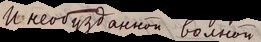

In [84]:
image

In [85]:
pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

–ò –Ω–µ–æ–±—É–∑–¥–∞–Ω–Ω–æ–π –≤–æ–ª–Ω–æ–π


In [61]:

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

–ù–∞–¥—ä –≤—£—á–Ω–æ –ø–ª–∞–º–µ–Ω–Ω–æ–π –∑–≤—£–∑–¥–æ–π!


In [86]:
eval_results = trainer.evaluate()

# Print the evaluation results
print("Evaluation results:", eval_results)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 43/43 [28:35<00:00, 39.90s/it]

Evaluation results: {'eval_loss': 0.15182630717754364, 'eval_cer': 0.05355100343142352, 'eval_runtime': 1761.218, 'eval_samples_per_second': 0.191, 'eval_steps_per_second': 0.024, 'epoch': 3.0}
